In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [3]:
@njit
def weighted_choice(choices, weights):
    total = np.sum(weights)
    r = np.random.rand()*total
    upto = 0
    for i,c in enumerate(choices):
        upto += weights[i]
        if upto >= r:
            return c
    assert False, "Shouldn't get here"

In [4]:
@njit
def insertRequest(queues, N):
    q_idx = np.random.randint(N) # rnd queue picker
#     q_idx = weighted_choice(range(queues.shape[0]), np.exp(np.sum(queues,axis=1)))
#     q_idx = weighted_choice(range(queues.shape[0]), 1+np.sum(queues,axis=1))
#     q_idx = weighted_choice(range(queues.shape[0]), 1+np.sum(np.sqrt(queues),axis=1))
#     q_idx = np.argmin(np.sum(queues,axis=1)) # smart queue picker

    neighbours = [0,-1,1]
    rejected = True
    for neighbour in neighbours:
        queue = queues[(q_idx+neighbour)%N]
        ones_idx = np.where(queue==1)[0]
        if queue[0] == 0:
            if ones_idx.size == 0:
                queue[-1] = 1
            else:
                if np.random.rand()<0.0:
                    queue[np.random.randint(ones_idx[0]+1)] = 1
                    queue[0] = 1
                else:
                    queue[ones_idx[0]-1] = 1
            rejected = False
            break

    return rejected

@njit
def timeStep(queues, N):
    for queue in queues:
        queue_occupancy = np.sum(queue)
        if queue_occupancy == 0:
            dq_rate = 0
        else:
            dq_rate = 1/(2*N)*(2-1/queue_occupancy)
        if np.random.rand() < dq_rate:
            queue[:] = np.roll(queue, 1)
            queue[0] = 0

In [5]:
# %%time
from IPython.display import clear_output
import sys

@njit
def compute(N,S,queues_track):
    times = np.arange(0,10000)
    queues = np.zeros((N,S))
    # rejected = np.zeros_like(in_rates)
    sum_rejected = 0
    # queues_track = np.empty((len(times),N,S))

    # queues *= 0
    for t in times:
    #     incoming = np.maximum(0,np.random.randint(in_rate-2,in_rate+3))
    #     queues = np.roll(queues, 1, axis=1)
        sum_rejected += insertRequest(queues, N)
        timeStep(queues, N)
        if not queues_track == None:
            queues_track[t,:,:] = queues
    #     queues_track[t] = queues
    #     rejected[i] += left_over
    return sum_rejected

In [10]:
%%time
N_queues = np.arange(1,10000,100)
S = 5

rejected = np.vectorize(compute)(N_queues, S)

TypeError: not enough arguments: expected 3, got 2

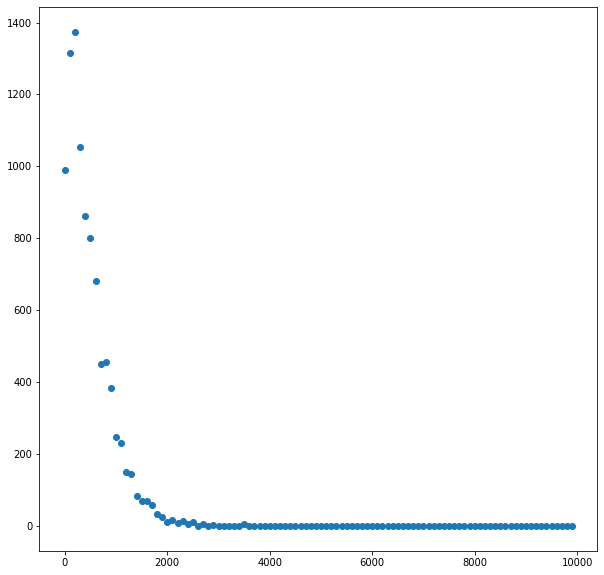

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(N_queues, rejected, "o")

plt.show()

In [6]:
N = 1
S = 5
queues_track = np.empty((10000,N,S))
rejected = compute(N, S, queues_track)

In [7]:
print(rejected)

980


<IPython.core.display.Javascript object>


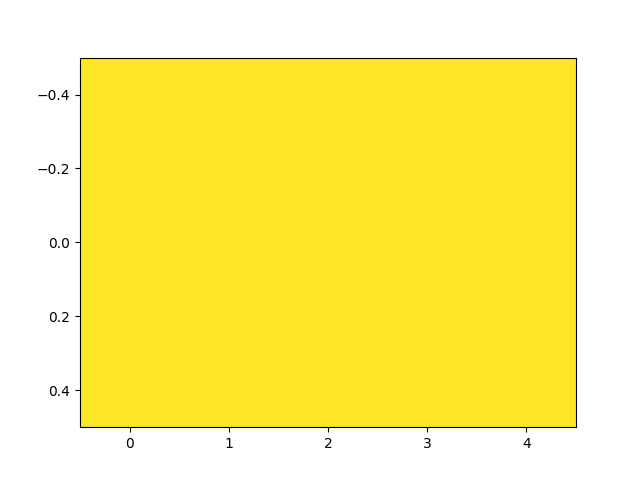

In [8]:
%matplotlib notebook
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
mat = ax.imshow(queues_track[0], aspect="auto")

# def prepare_animator(mat_container):
#     def animate(frame_number):
#         data = queues_track[frame_number]
#         mat_containter.set_data(data)
#         return mat_container
#     return animate

# def init():
#     mat.set_data(np.zeros(queues_track.shape[1:]))
#     return mat,

def animate(frame_number):
    data = queues_track[frame_number]
    mat.set_data(data)
    return mat,
        
anim = animation.FuncAnimation(fig, animate, len(queues_track), interval=50, repeat=False, blit=True)
plt.show()

# HTML(anim.to_html5_video())

In [40]:
plt.scatter(in_rates, rejected)
plt.xlabel("incoming rate")
plt.ylabel("rejected")
plt.xlim(0,None)
plt.ylim(0,None)

plt.show()

NameError: name 'in_rates' is not defined

In [113]:
class queue:
    def __init__(self, buffer_size):
        self.q_ = np.empty(buffer_size)
    def insert(self, a):
        self.q_[0] = a
    def print_me(self):
        print(self.q_)

In [24]:
@njit
def distributeOnQueues(queues, n):
    queues_idx = np.arange(queues.shape[0])
    reject = 0
    while n!=0 and np.any(queues==0):
        n -= 1
        rej_flag = True
        q_idx = np.random.randint(N) # rnd queue picker
#         q_idx = weighted_choice(queues_idx, np.exp(np.sum(queues,axis=1)))
#         q_idx = np.argmin(np.sum(queues,axis=1)) # smart queue picker
        
        for neighbour in [0,1,-1]:
            queue = queues[(q_idx+neighbour)%N]
            free_idx = np.where(queue==0)[0]
            if free_idx.size > 0:
                queue[free_idx[-1]] = 1
                rej_flag = False
                break
                
        if rej_flag:
            reject += 1
    
    reject += n
    return reject